In [1]:
%load_ext autoreload
%autoreload 2

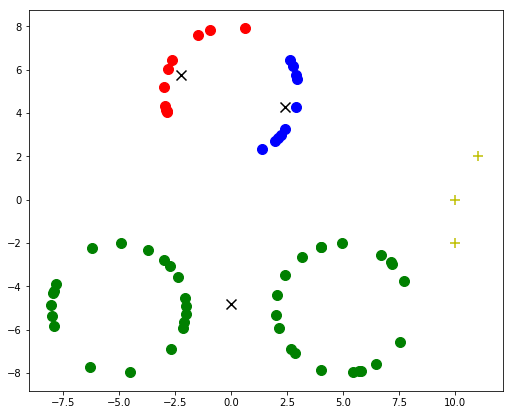

In [3]:
import numpy as np
from numpy import random as rand
from numpy import linalg as lin
import random
from cs771 import genSyntheticData as gsd
from cs771 import plotData as pd
from cs771 import utils
from keras.datasets import mnist
import matplotlib as mpl
from matplotlib import pyplot as plt

d = 2 
n = 20
r = 3

mu1 = np.array( [0,5] )
mu2 = np.array( [-5,-5] )
mu3 = np.array( [5,-5] )

tmp1 = gsd.genSphericalData( d, n, mu1, r )
tmp2 = gsd.genSphericalData( d, n, mu2, r )
tmp3 = gsd.genSphericalData( d, n, mu3, r )
X = np.vstack( (tmp1, tmp2, tmp3) )

# Perform soft assignments
def getSoftAssignments( X, muVals ):
    pi = np.exp( -utils.getAllPairsDistances( X, muVals )/2 )
    rowSum = pi.sum( axis = 1 )
    pi = pi / rowSum[:, np.newaxis]
    return pi

# Update every centroid to the weighted mean of all data points
def updateCentroidsSoftly( X, pi, k, prevMuVals ):
    muVals = np.zeros( (k, X.shape[1]) )
    for i in range( k ):
        z = pi[:, i]
        amountData = sum(z)
        # Recall that in soft clustering, only part of a data point may be assigned to a cluster
        # Thus, amountData could be a fractional value as well
        if amountData > 1:
            muVals[i,:] = (X.T).dot(z)/amountData
        # If some cluster is almost empty, return the old value of its centroid
        else:
            muVals[i,:] = prevMuVals[i,:]
    return muVals

# Execute the soft k-means (i.e. the EM) algorithm
def doSoftkmeans( X, k, init, niter ):
    muVals = init
    # Perform the EM algorithm for niter steps
    for t in range( niter ):
        pi = getSoftAssignments( X, muVals ) # E Step
        muVals = updateCentroidsSoftly( X, pi, k, muVals ) # M Step
    return (muVals, pi)

init = np.array( [[10,0], [10,-2], [11,2]] )
# Even the soft k-means algorithm (EM algorithm) can get stuck if not initialized properly
# Proper initialization is an absolute must for the EM algorithm as well
# No matter how long we run EM, it does not get unstuck
(muVals, pi) = doSoftkmeans( X, 3, init, 1000)

fig = pd.getFigure( 8.5, 7 )
pd.plot2D( X[pi[:,0] > 0.5 ], fig, color = 'r', marker = 'o' )
pd.plot2D( X[pi[:,1] > 0.5 ], fig, color = 'g', marker = 'o' )
pd.plot2D( X[pi[:,2] > 0.5 ], fig, color = 'b', marker = 'o' )
pd.plot2D( muVals, fig, color = 'k', marker = 'x' )
pd.plot2D( init, fig, color = 'y', marker = '+' )

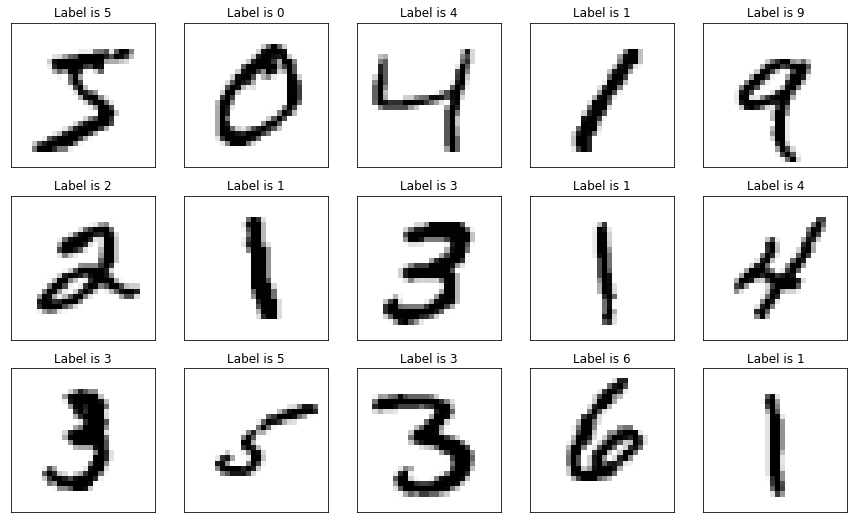

In [4]:
# Caution: when executing this line for the first time, sklearn will attempt to download
# this dataset from an internet source -- make sure you have a working internet connection
((XTrain, yTrain), (XTest, yTest)) = mnist.load_data()
n = XTrain.shape[0]
# What is the shape of these images?
imShape = XTrain.shape[1:]

# Normalize data coordinates otherwise numbers in later calculations explode
XTrain = XTrain/256

numRows = 3
numCols = 5

# Show the first 15 images in the dataset
fig2, axs2 = pd.getFigList( numRows, numCols )
labels = ["Label is %s" % yTrain[i] for i in range( numRows * numCols )]
pd.showImagesNoAxes( axs2, XTrain[:numRows*numCols], numRows, numCols, labelList = labels )

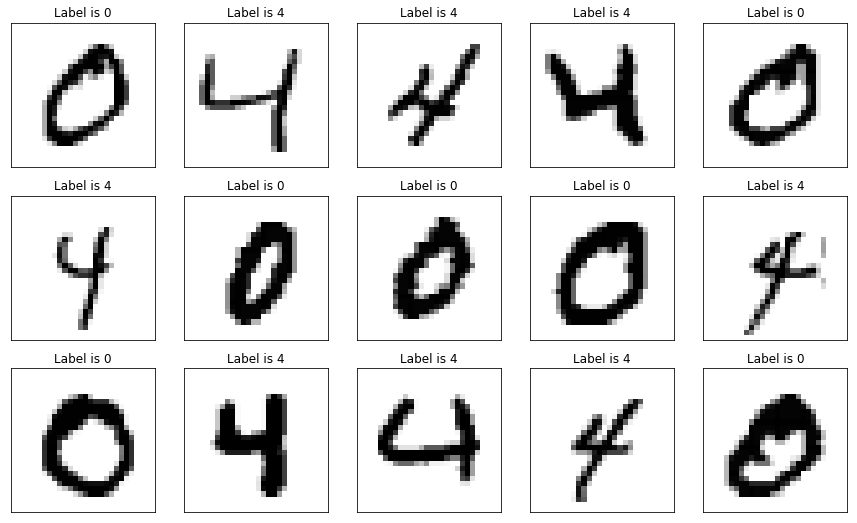

In [5]:
def getDataSubset( labels ):
    subset = np.in1d( yTrain, labels )
    return (XTrain[subset][:][:], yTrain[subset])

# Create a mini-dataset out of just the zeros and the fours
labels = np.array( [0,4] )
(X,y) = getDataSubset( labels )

# Flatten images for sake of convenience even though it is time consuming and not essential at all
n = X.shape[0]
d = np.prod( X.shape[1:] )
X = X.reshape( n, d )

# Display the first few images of this subset dataset
fig3, axs3 = pd.getFigList( numRows, numCols )
labels = ["Label is %s" % y[i] for i in range( numRows * numCols )]
pd.showImagesNoAxes( axs3, X[:numRows*numCols], numRows, numCols, resize = True, imShape = imShape, labelList = labels )

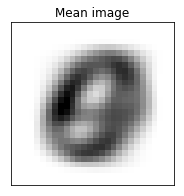

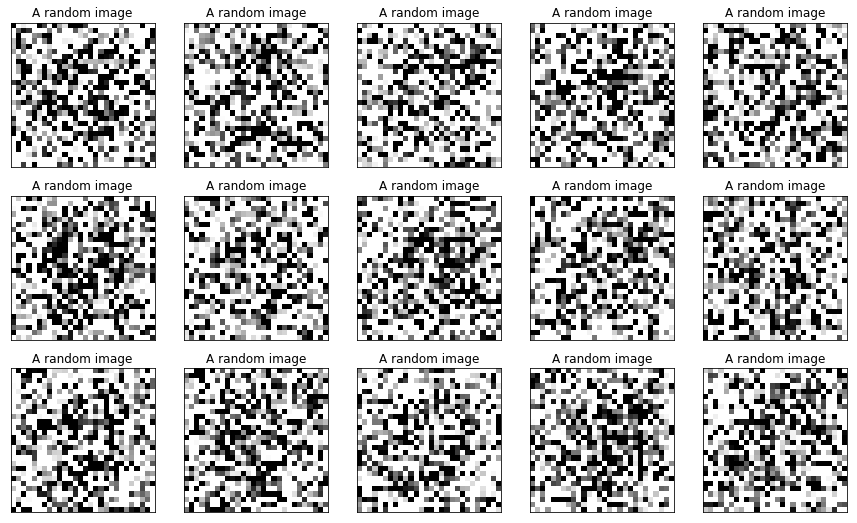

In [6]:
def fitSingleStandardGaussian( X ):
    return np.mean( X, axis = 0 )

def truncatePixels( X, low = 0, high = 1 ):
    X[X < low] = low
    X[X > high] = high
    return X

# Fit a standard Gaussian to the 0,4 dataset using an MLE
mu = fitSingleStandardGaussian( X )
fig4, axs4 = pd.getFigList( 1, 1 )
labels = ["Mean image"]
pd.showImagesNoAxes( axs4, mu[np.newaxis,:], 1, 1, resize = True, imShape = imShape, labelList = labels )

# Display a few samples taken from this distribution -- you will find these to be extremely noisy
fig5, axs5 = pd.getFigList( numRows, numCols )
labels = ["A random image" for i in range( numRows * numCols )]
randSamples = rand.multivariate_normal( mu, np.identity( d ), size = numRows * numCols, check_valid = "raise" )
randSamples = truncatePixels(randSamples)
pd.showImagesNoAxes( axs5, randSamples, numRows, numCols, resize = True, imShape = imShape, labelList = labels )

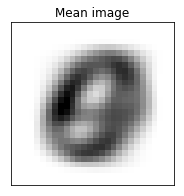

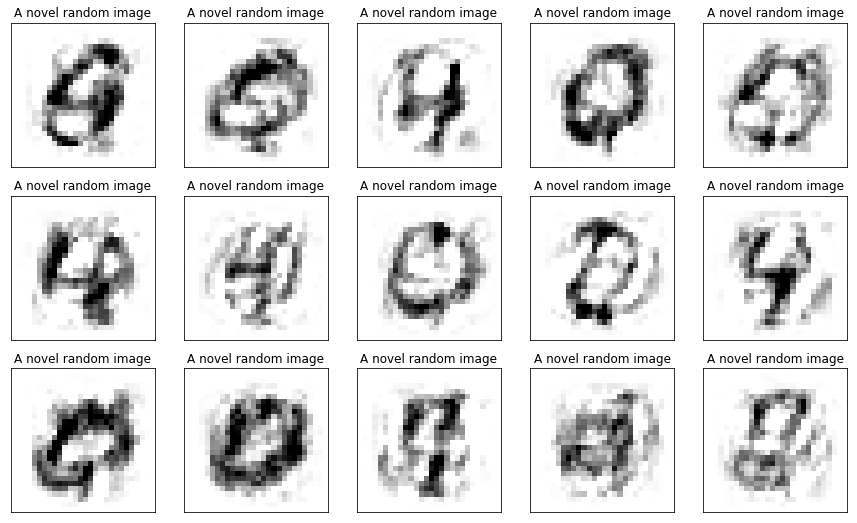

In [7]:
def fitSingleGaussian( X ):
    n = X.shape[0]
    d = np.prod( X.shape[1:] )
    X = X.reshape( n, d )
    mu = np.mean( X, axis = 0 )
    Xcent = X - mu
    cov = 1/n*(Xcent.T).dot(Xcent)
    return (mu, cov)

# Fit a general Gaussian this time to the same dataset
(mu, cov) = fitSingleGaussian( X )

fig6, axs6 = pd.getFigList( 1, 1 )
labels = ["Mean image"]
pd.showImagesNoAxes( axs6, mu[np.newaxis,:], 1, 1, resize = True, imShape = imShape, labelList = labels )

# The quality of samples is a bit better due to use of a general covariance matrix but not much better
fig7, axs7 = pd.getFigList( numRows, numCols )
labels = ["A novel random image" for i in range( numRows * numCols )]
randSamples = rand.multivariate_normal( mu, cov, size = numRows * numCols, check_valid = "raise" )
randSamples = truncatePixels(randSamples)
pd.showImagesNoAxes( axs7, randSamples, numRows, numCols, resize = True, imShape = imShape, labelList = labels )

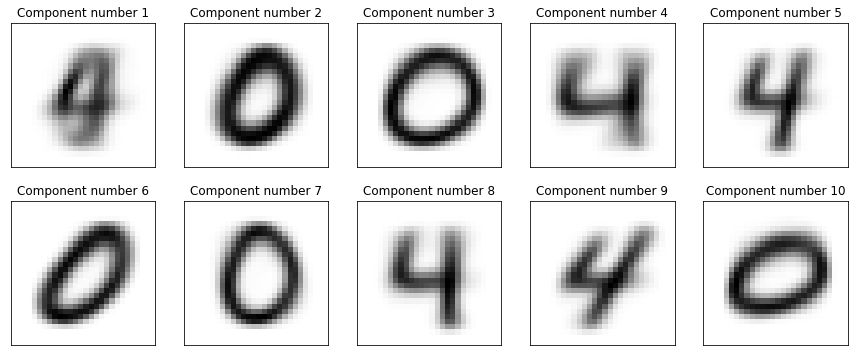

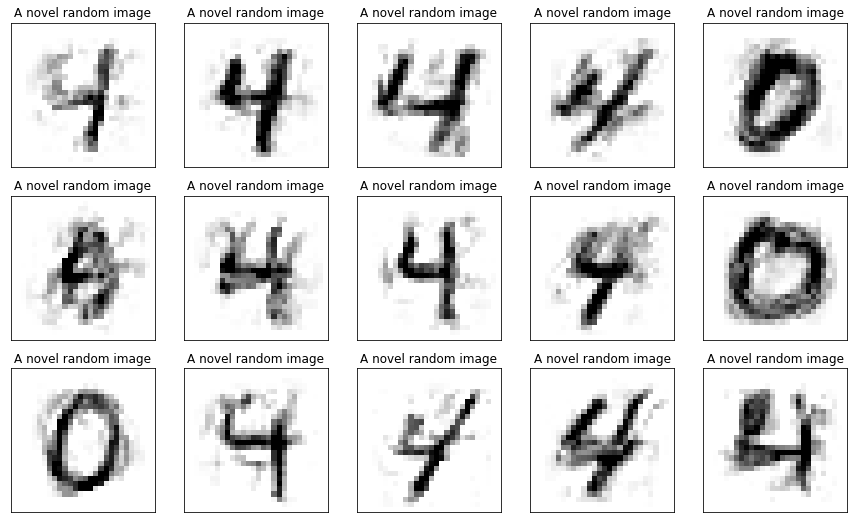

In [8]:
# Perform the k-means++ initialization
def doKMPPInitGreedy( X, k ):
    init = np.zeros( (k, X.shape[1]) )
    n = X.shape[0]
    # Choose a random data point and make it a centroid
    i = random.randint( 0, n-1 )
    init[0,:] = X[i,:]
    for t in range( 1, k ):
        # For all data points, find the squared Euclidean distance to the closest centroid
        # Python is funny: init[0,:] generates a vector but init[0:1,:] generates a matrix with one row :)
        dist = np.min( utils.getAllPairsDistances( X, init[0:t,:] ), axis = 1 )
        i = np.argmax( dist )
        init[t,:] = X[i,:]
    return init

def getSigmaInit( k, d ):
    iden = np.identity( d )
    init = np.zeros( (k, d, d) )
    for i in range( k ):
        init[i] = iden
    return init

# Obtain probability of data point x^i belonging to component N(\mu^c, S^c)
# The proper way of computing this is 1/\sqrt((2\pi)^d*|S^c|)*exp( - (x^i - \mu^c)'(S^c)^{-1}(x^i - \mu^c))
# However, this can be very expensive due to all the inverses involved
# Cheaper shortcut: approximate S^c \approx I_d
def doEStep( X, muVals, SigmaVals ):
    qVals = np.exp( -utils.getAllPairsDistances( X, muVals ) / 2 )        
    rowSum = qVals.sum( axis = 1 )
    qVals = qVals / rowSum[:, np.newaxis]
    return qVals

# Update the models by optimizing the Q function given by the E Step
# Ideally, both means and covariances for all components should be updated
# The solution to the weighted MLE for the covariance matrix update can be shown to be
# S^c = 1/Q_c * \sum_{i=1}^n q^i_c (x^i - \mu^c)(x^i - \mu^c)^T where Q_c = \sum_{i=1}^n q^i_c
# Cheaper shortcut: do not update covariance matrix at every M step (update only means every time)
# Update covariance only at the end (we are anyway not using SigmaVals to compute the E step)
def doMStep( X, qVals, C, prevMuVals, prevSigmaVals ):
    d = X.shape[1]
    muVals = np.zeros( (C, d) )
    SigmaVals = np.zeros( (C, d, d) )
    
    # Process every component
    for c in range( C ):
        # Get hold of the weights different data points have given to this component
        q = qVals[:, c]
        amountData = sum(q)
        # If there is enough data for this component, do weighted MLE estimation
        if amountData > 1:
            muVals[c] = (X.T).dot( q )/amountData
        # If some cluster is almost empty, return the old value of its centroid
        else:
            muVals[c] = prevMuVals[c]
    return (muVals, SigmaVals)

# Execute EM algorithm for jointly learning a mixture of general (not standard) Gaussians
def doEMGMM( X, C, initMu, initSigma, niter ):
    muVals = initMu
    SigmaVals = initSigma
    # Perform the EM algorithm for niter steps
    for t in range( niter ):
        qVals = doEStep( X, muVals, SigmaVals )
        (muVals, SigmaVals) = doMStep( X, qVals, C, muVals, SigmaVals )
    # Cheaper shortcut we employed -- doing costly S^c updates only once at the end
    for c in range( C ):
        q = qVals[:, c]
        amountData = sum(q)
        if amountData > 1:
            Xcent = X - muVals[c]
            wXCent = (Xcent.T * q).T
            SigmaVals[c] = 1 / amountData * (wXCent.T).dot( Xcent )
    return (muVals, SigmaVals, qVals)

# Number of components in the Gaussian mixture model (GMM)
C = 10
niter = 5

initMu = doKMPPInitGreedy( X, C )
initSigma = getSigmaInit( C, X.shape[1] )
(muVals, SigmaVals, qVals) = doEMGMM( X, C, initMu, initSigma, niter )
        
numRows = 2
numCols = C//2

# Visualize the means/modes of the various components the EM algorithm returned
# Notice how the various components do not just capture the different digits but also
# different ways/styles of writing each digit e.g. slanted 0 vs fat round 0 etc
fig8, axs8 = pd.getFigList( numRows, numCols )
labels = ["Component number %s" % (i+1) for i in range( numRows * numCols )]
pd.showImagesNoAxes( axs8, muVals, numRows, numCols, resize = True, imShape = imShape, labelList = labels )

numRows = 3
numCols = 5

fig9, axs9 = pd.getFigList( numRows, numCols )
labels = ["A novel random image" for i in range( numRows * numCols )]
randSamples = np.zeros( (numRows * numCols, d) )
for i in range( numRows * numCols ):
    # Choose a random component of the GMM from which to sample
    # It should be noted here that we have not used the label information in the data at all
    # All these results are being achieved in a completely "unsupervised" setting
    # Also note that all of these are novel images -- that never appeared in the training set
    # Notice the significantly improved quality of the novel images compared to previous attempts
    idx = random.randint( 0, C - 1 )
    randSamples[i] = rand.multivariate_normal( muVals[idx], SigmaVals[idx], check_valid = "raise" )

randSamples = truncatePixels(randSamples)
pd.showImagesNoAxes( axs9, randSamples, numRows, numCols, resize = True, imShape = imShape, labelList = labels )

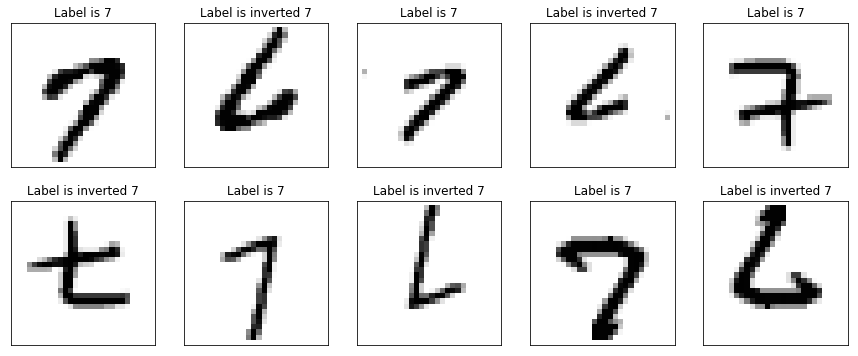

In [9]:
# Create a dataset of upright and inverted 7s. Notice that an upight 7 means that there are black pixels
# in the top, right regions and the top-right corner. An inverted 7, on the other hand means that there are
# black pixels in the bottom, left regions and the bottom-left corner.
labels = np.array( [7] )
(X,y) = getDataSubset( labels )
Xinv = X[:,::-1,::-1]
n = X.shape[0]
d = np.prod( X.shape[1:] )
X = X.reshape( n, d )
Xinv = Xinv.reshape( n, d )

Xcomb = np.zeros( (2 * n, d) )
Xcomb[::2] = X
Xcomb[1::2] = Xinv

n = 2 * n

numRows = 2
numCols = 5

fig10, axs10 = pd.getFigList( numRows, numCols )
labels = ["" for i in range( numRows * numCols )]
labels1 = ["Label is %s" % y[i] for i in range( (numRows * numCols) // 2 )]
labels2 = ["Label is inverted %s" % y[i] for i in range( (numRows * numCols) // 2 )]
labels[::2] = labels1
labels[1::2] = labels2

pd.showImagesNoAxes( axs10, Xcomb[:numRows*numCols], numRows, numCols, resize = True, imShape = imShape, labelList = labels )

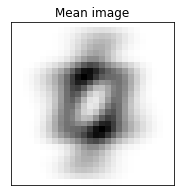

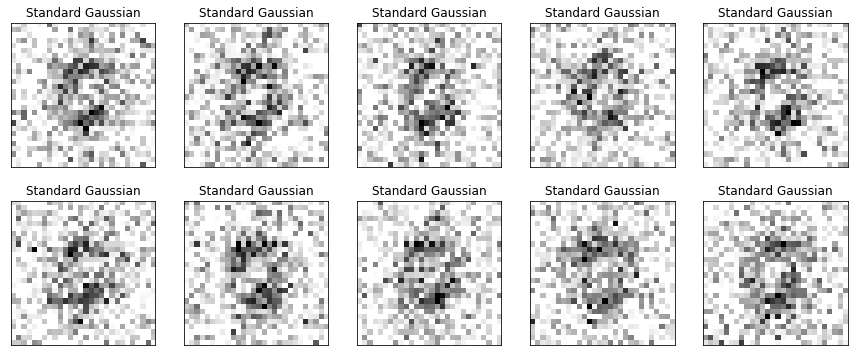

In [10]:
# Fitting a "spherical" Gaussian i.e. whose covariance matrix is a multiple of the identity matrix
# gives very poor samples since such a distribution is incapable of storing the fact that in the 
# current dataset, if there are black pixels in the top-right region, then the bottom-left region
# is largely vacant and vice versa. Only covariance among different pixels can allow a distribution
# to store such information about correlated behavior among pixels
mu = fitSingleStandardGaussian( Xcomb )
sigmaSq = np.square( lin.norm( Xcomb - mu, 'fro' ) ) / (n * d)

fig11, axs11 = pd.getFigList( 1, 1 )
labels = ["Mean image"]
pd.showImagesNoAxes( axs11, mu[np.newaxis,:], 1, 1, resize = True, imShape = imShape, labelList = labels )

fig12, axs12 = pd.getFigList( numRows, numCols )
labels = ["Standard Gaussian" for i in range( numRows * numCols )]
randSamples = rand.multivariate_normal( mu, sigmaSq*np.identity( d ), size = numRows * numCols, check_valid = "raise" )
randSamples = truncatePixels(randSamples)
pd.showImagesNoAxes( axs12, randSamples, numRows, numCols, resize = True, imShape = imShape, labelList = labels )

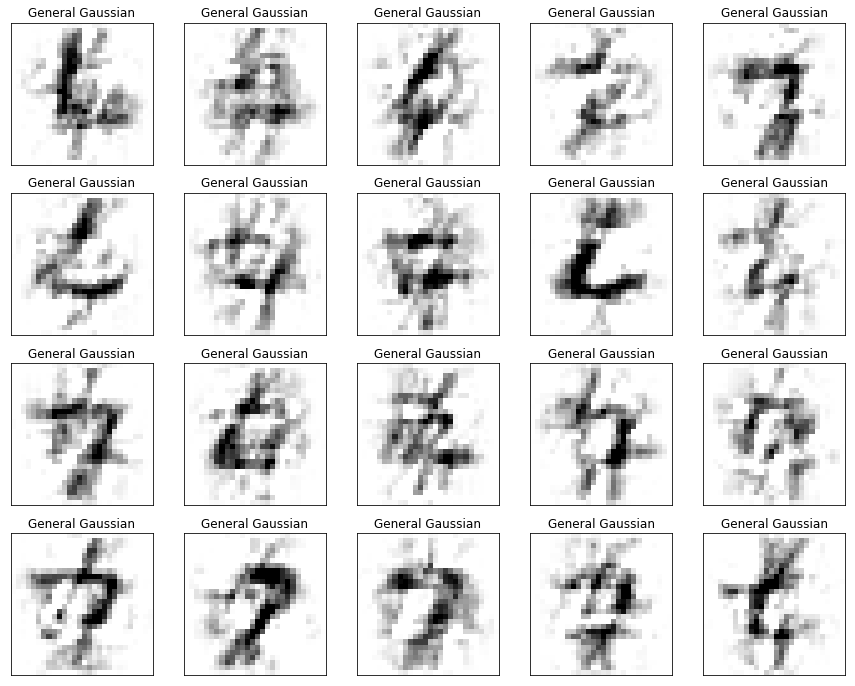

In [14]:
# Using a proper Gaussian with a general covariance allows even a single Gaussian to capture
# the fact that there exist upright and inverted 7s in this dataset and give much better samples
(mu, cov) = fitSingleGaussian( Xcomb )

numRows = 4
numCols = 5

fig13, axs13 = pd.getFigList( numRows, numCols )
labels = ["General Gaussian" for i in range( numRows * numCols )]
randSamples = rand.multivariate_normal( mu, cov, size = numRows * numCols, check_valid = "raise" )
randSamples = truncatePixels(randSamples)
pd.showImagesNoAxes( axs13, randSamples, numRows, numCols, resize = True, imShape = imShape, labelList = labels )